# PoseNet for Self-Localization Task on Apolloscape Dataset

PoseNet implementation on Apolloscape dataset. It's a part of the localization methods exploration for Apolloscape Self-Localization Challenge on [ECCV 2018](http://apolloscape.auto/ECCV/challenge.html)

In [1]:
# Load all dependency
%load_ext autoreload
%autoreload 2

from IPython.display import HTML
from IPython.display import clear_output

import numpy as np

import torch
from torch import nn
from torchvision import transforms, models
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchviz import make_dot

from datasets.apolloscape import Apolloscape
from datasets.tum import TUM

from utils.common import draw_poses
from utils.common import draw_record
from utils.common import imshow
from utils.common import save_checkpoint
from utils.common import AverageMeter
from utils.common import calc_poses_params, quaternion_angular_error

from models.posenet import PoseNet, PoseNetCriterion

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image

from tqdm import tqdm
import os
import time
from datetime import datetime

%matplotlib inline
plt.ion()


## Load Apolloscape Dataset

`APOLLO_PATH` is a location with unpacked Apolloscape datasets, e.g. `$APOLLO_PATH/road02_seg` or `$APOLLO_PATH/zpark`. Download data from [Apolloscape page](http://apolloscape.auto/scene.html) and unpack it to the `APOLLO_PATH` dir. Let's we've symbolically linked `APOLLO_PATH` folder to `./data/apolloscape`.

In [2]:
APOLLO_PATH = "/home/sufferlinux/Downloads/derbyml"
#zpark = dataset
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# Resize data before using
transform = transforms.Compose([
    transforms.Resize(260),
    transforms.CenterCrop(250),
#     transforms.Resize((224, 672)),
    transforms.ToTensor(),
    normalize
])

experiment_name = "T03"

pretrained = True
stereo = False
shuffle = True

batch_size = 64

record_list = ['sequence_01', 'sequence_03', 'sequence_04', 'sequence_05', 'sequence_06', 
               'sequence_07', 'sequence_08', 'sequence_09', 'sequence_10']

train_list = [ TUM(root=os.path.join(APOLLO_PATH), road="TUM",
                             transform=transform, record=k, normalize_poses=True,
                             pose_format='quat', train=True, cache_transform=True, stereo=stereo)\
                             for k in record_list]

# train_record = "sequence_01"
# train_dataset = TUM(root=os.path.join(APOLLO_PATH), road="TUM",
#                              transform=transform, record=train_record, normalize_poses=True,
#                              pose_format='quat', train=True, cache_transform=True, stereo=stereo)

val_record = "sequence_02"
val_dataset = TUM(root=os.path.join(APOLLO_PATH), road="TUM",
                             transform=transform, record=val_record, normalize_poses=True,
                             pose_format='quat', train=False, cache_transform=True, stereo=stereo)


# print(train_dataset)
print(val_dataset)

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2) # batch_size = 75
train_dataloader_list = [ DataLoader(i, batch_size=batch_size, shuffle=shuffle, num_workers=2) 
                          for i in train_list]# batch_size = 75
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2) # batch_size = 75


pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
image_dir_read_all_data =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir_read_all_data =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
records_list_read_all_data =  ['sequence_01', 'sequence_02', 'sequence_03', 'sequence_04', 'sequence_05']
cameras_list_read_all_data =  ['image', 'image']
0 pose_len =  968
1 pose_len =  796
2 pose_len =  1409
3 pose_len =  859
4 pose_len =  1053
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
image_dir_read_all_data =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir_read_all_data =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
records_list_read_all_data =  ['sequence_01', 'sequence_02', 'sequence_03', 'sequence_04', 'sequence_05']
cameras_list_read_all_data =  ['image', 'image']
0 pose_len =  968
1 pose_len =  796
2 pose_len =  1409
3 pose_len =  859
4 pose_len =  1053
Dataset: TUM
    Road: TUM
    Record: sequence_01
    Train: True
    Norma

In [3]:
_,pose = train_dataset[0]
print(pose)

tensor([-1.7070, -0.3329, -1.9438,  0.5747,  0.3623, -0.3430,  0.6487])


## Draw Train and Val datasets

Visualize poses from `train` and `val` datasets to check that it covers all val path.

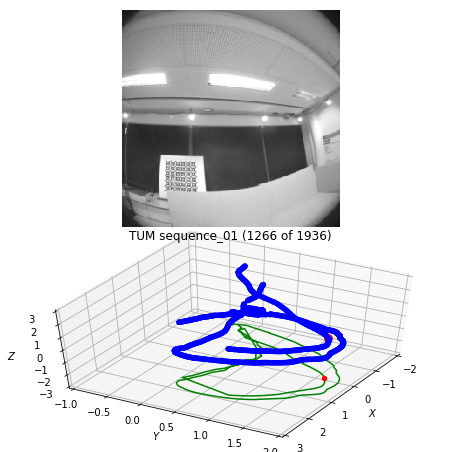

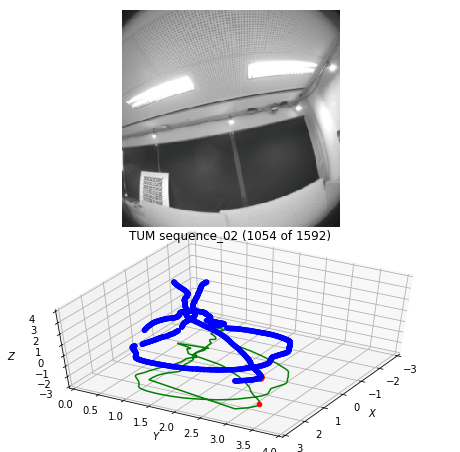

In [4]:
# Draw datasets
# draw_record(train_dataset)
draw_record(train_list[0])
plt.show()

draw_record(val_dataset)
plt.show()


## Device set up

Determine the primary device and use it for training/validation.

In [5]:
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('device = {}'.format(device))

device = cuda


## Train and Validate Functions

Train function runs one epoch through training data.

In [6]:
# train function
def train(train_loader, model, criterion, optimizer, epoch, max_epoch, log_freq=1, print_sum=True,
          poses_mean=None, poses_std=None, stereo = True):
    
    # switch model to training
    model.train()
    
    losses = AverageMeter()
    
    epoch_time = time.time()
    
    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))

    
    end = time.time()
    for idx, (batch_images, batch_poses) in enumerate(train_loader):
        data_time = (time.time() - end)
        
        if stereo:
            batch_images = [x.to(device) for x in batch_images]
            batch_poses = [x.to(device) for x in batch_poses]
        else:
            batch_images = batch_images.to(device)
            batch_poses = batch_poses.to(device)
        
        out = model(batch_images)
        loss = criterion(out, batch_poses)
#         print('loss = {}'.format(loss))

        
        # Training step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.update(loss.data[0], len(batch_images) * batch_images[0].size(0) if stereo
                else batch_images.size(0))
        
        
        # move data to cpu & numpy
        if stereo:
            bp = [x.detach().cpu().numpy() for x in batch_poses]
            outp = [x.detach().cpu().numpy() for x in out]
            gt_poses = np.vstack((gt_poses, *bp))
            pred_poses = np.vstack((pred_poses, *outp))
        else:
            bp = batch_poses.detach().cpu().numpy()
            outp = out.detach().cpu().numpy()
            gt_poses = np.vstack((gt_poses, bp))
            pred_poses = np.vstack((pred_poses, outp))
        
        
        batch_time = (time.time() - end)
        end = time.time()
        
        if log_freq != 0 and idx % log_freq == 0:
            print('Epoch: [{}/{}]\tBatch: [{}/{}]\t'
                  'Time: {batch_time:.3f}\t'
                  'Data Time: {data_time:.3f}\t'
                  'Loss: {losses.val:.3f}\t'
                  'Avg Loss: {losses.avg:.3f}\t'.format(
                   epoch, max_epoch - 1, idx, len(train_loader) - 1,
                   batch_time=batch_time, data_time=data_time, losses=losses))

            
    # un-normalize translation
    unnorm = (poses_mean is not None) and (poses_std is not None)
    if unnorm:
        gt_poses[:, :3] = gt_poses[:, :3] * poses_std + poses_mean
        pred_poses[:, :3] = pred_poses[:, :3] * poses_std + poses_mean
    
    t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
    q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

#     if unnorm:
#         print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
#     print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
#     print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

            
    if print_sum:
        print('Ep: [{}/{}]\tTrain Loss: {:.3f}\tTe: {:.3f}\tRe: {:.3f}\t Et: {:.2f}s\t{criterion_sx:.5f}:{criterion_sq:.5f}'.format(
            epoch, max_epoch - 1, losses.avg, np.mean(t_loss), np.mean(q_loss),
            (time.time() - epoch_time), criterion_sx=criterion.sx.data[0], criterion_sq=criterion.sq.data[0]))
        
#     return losses.avg
    
    
# def validate(val_loader, model, criterion, epoch, log_freq=1, print_sum=True, stereo=True):
    
#     losses = AverageMeter()
    
#     # set model to evaluation
#     model.eval()
    
#     with torch.no_grad():
#         epoch_time = time.time()
#         end = time.time()
#         for idx, (batch_images, batch_poses) in enumerate(val_loader):
#             data_time = time.time() - end
            
#             if stereo:
#                 batch_images = [x.to(device) for x in batch_images]
#                 batch_poses = [x.to(device) for x in batch_poses]
#             else:
#                 batch_images = batch_images.to(device)
#                 batch_poses = batch_poses.to(device)
            
#             # compute model output
#             out = model(batch_images)
#             loss = criterion(out, batch_poses)
            
#             losses.update(loss.data[0], len(batch_images) * batch_images[0].size(0) if stereo
#                     else batch_images.size(0))
            
#             batch_time = time.time() - end
#             end = time.time()
            
#             if log_freq != 0 and idx % log_freq == 0:
#                 print('Val Epoch: {}\t'
#                       'Time: {batch_time:.3f}\t'
#                       'Data Time: {data_time:.3f}\t'
#                       'Loss: {losses.val:.3f}\t'
#                       'Avg Loss: {losses.avg:.3f}'.format(
#                        epoch, batch_time=batch_time, data_time=data_time, losses=losses))
                
    
#     if print_sum:
#         print('Epoch: [{}]\tValidation Loss: {:.3f}\tEpoch time: {:.3f}'.format(epoch, losses.avg,
#                                                                                (time.time() - epoch_time)))
        
# #     return losses.avg


In [7]:
def validate(val_loader, model, criterion, epoch, log_freq=1, print_sum=True, 
             poses_mean=None, poses_std=None, stereo=True):
    
    losses = AverageMeter()
    
    # set model to evaluation
    model.eval()
    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))
    
    with torch.no_grad():
        epoch_time = time.time()
        end = time.time()
        for idx, (batch_images, batch_poses) in enumerate(val_loader):
            data_time = time.time() - end
            
            if stereo:
                batch_images = [x.to(device) for x in batch_images]
                batch_poses = [x.to(device) for x in batch_poses]
            else:
                batch_images = batch_images.to(device)
                batch_poses = batch_poses.to(device)
            
            # compute model output
            out = model(batch_images)
            loss = criterion(out, batch_poses)
            
            losses.update(loss.data[0], len(batch_images) * batch_images[0].size(0) if stereo
                    else batch_images.size(0))
                    # move data to cpu & numpy
            if stereo:
                bp = [x.detach().cpu().numpy() for x in batch_poses]
                outp = [x.detach().cpu().numpy() for x in out]
                gt_poses = np.vstack((gt_poses, *bp))
                pred_poses = np.vstack((pred_poses, *outp))
            else:
                bp = batch_poses.detach().cpu().numpy()
                outp = out.detach().cpu().numpy()
                gt_poses = np.vstack((gt_poses, bp))
                pred_poses = np.vstack((pred_poses, outp))
            
            batch_time = time.time() - end
            end = time.time()
            
            if log_freq != 0 and idx % log_freq == 0:
                print('Val Epoch: {}\t'
                      'Time: {batch_time:.3f}\t'
                      'Data Time: {data_time:.3f}\t'
                      'Loss: {losses.val:.3f}\t'
                      'Avg Loss: {losses.avg:.3f}'.format(
                       epoch, batch_time=batch_time, data_time=data_time, losses=losses))
    
    # un-normalize translation
    unnorm = (poses_mean is not None) and (poses_std is not None)
    if unnorm:
        gt_poses[:, :3] = gt_poses[:, :3] * poses_std + poses_mean
        pred_poses[:, :3] = pred_poses[:, :3] * poses_std + poses_mean
    
    t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
    q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])           
    
    if print_sum:
        # print('Epoch: [{}]\tValidation Loss: {:.3f}\tEpoch time: {:.3f}'.format(epoch, losses.avg,
        #                                                                        (time.time() - epoch_time)))
        print('Epoch: [{}]\tValidation Loss: {:.3f}\tTe: {:.3f}\tRe: {:.3f}\t Et: {:.2f}s\t'.format(
            epoch, losses.avg, np.mean(t_loss), np.mean(q_loss),(time.time() - epoch_time)))

## Create Model, Criterion and Optimizer

PoseNet implementation is a ResNet based feature extractor that ends with custom fully-connected regressor layers for translation (3D pose) and rotation (quaternion).

In [13]:
# Create pretrained feature extractor
# feature_extractor = models.resnet18(pretrained=True)
feature_extractor = models.resnet34(pretrained=pretrained)
# feature_extractor = models.resnet50(pretrained=True)

# Num features for the last layer before pose regressor
num_features = 2048

# Create model
model = PoseNet(feature_extractor, num_features=num_features, pretrained=pretrained)
model = model.to(device)

# Criterion
# criterion = PoseNetCriterion(stereo=stereo, beta=500.0)
criterion = PoseNetCriterion(stereo=stereo, learn_beta=True)
criterion = criterion.to(device)

# Add all params for optimization
param_list = [{'params': model.parameters()}]
if criterion.learn_beta:
    param_list.append({'params': criterion.parameters()})

# Create optimizer
optimizer = optim.Adam(params=param_list, lr=1e-5, weight_decay=0.0005)

start_epoch = 0


## Restore from Chekpoint

It helps to continue training later or just use it for the inference.

In [14]:
# Restore from checkpoint
# checkpoint_file = '_checkpoints/20180823_085404_zpark_posenet_L1_resnet34p_2048_e2880.pth.tar'
# checkpoint_file = '_checkpoints/20180824_084414_nb_zpark_L6_e002.pth.tar'

# if 'checkpoint_file' in locals() and checkpoint_file is not None:
#     if os.path.isfile(checkpoint_file):
#         print('Loading from checkpoint: {}'.format(checkpoint_file))
#         checkpoint = torch.load(checkpoint_file)
#         model.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optim_state_dict'])
#         start_epoch = checkpoint['epoch']
#         if 'criterion_state_dict' in checkpoint:
#             criterion.load_state_dict(checkpoint['criterion_state_dict'])
#             print('Loaded criterion params.')



## Run Training

Training loop that runs for `n_epochs` with validation every `val_freq` epochs.

In [23]:
if 'start_epoch' not in locals():
    start_epoch = 0
# optimizer = optim.Adam(params=param_list, lr=1e-7, weight_decay=0.0004)    
n_epochs = start_epoch + 200

print('Training ...')
c_freq = 5
val_freq = 20
dset_num = np.arange(len(train_list))
for e in range(start_epoch, n_epochs):
    if e % c_freq == 0 and e != 0:
        idx = int (random.choice(dset_num))
        train_dataloader = train_dataloader_list[idx]
        print("========= Train on Dataset =======", record_list[idx])
    train(train_dataloader, model, criterion, optimizer, e, n_epochs, log_freq=0,
         poses_mean=train_list[idx].poses_mean, poses_std=train_list[idx].poses_std, stereo=stereo)
    if e % val_freq == 0:
#         end = time.time()
#         validate(val_dataloader, model, criterion, e, log_freq=0, stereo=stereo)
        validate(val_dataloader, model, criterion, e, log_freq=0, poses_mean=val_dataset.poses_mean, 
                poses_std=val_dataset.poses_std, stereo=stereo)

start_epoch = n_epochs

print('n_epochs = {}'.format(n_epochs))


Training ...
Ep: [400/599]	Train Loss: -2.979	Te: 0.299	Re: 8.433	 Et: 5.68s	0.06526:-3.06517
Epoch: [400]	Validation Loss: -1.503	Te: 1.496	Re: 25.983	 Et: 2.06s	
Ep: [401/599]	Train Loss: -2.980	Te: 0.304	Re: 8.303	 Et: 5.68s	0.06553:-3.06548
Ep: [402/599]	Train Loss: -2.980	Te: 0.302	Re: 8.302	 Et: 5.47s	0.06580:-3.06579
Ep: [403/599]	Train Loss: -2.983	Te: 0.318	Re: 8.175	 Et: 5.47s	0.06607:-3.06610
Ep: [404/599]	Train Loss: -2.982	Te: 0.308	Re: 8.216	 Et: 5.47s	0.06635:-3.06641
Ep: [405/599]	Train Loss: -2.984	Te: 0.304	Re: 8.246	 Et: 5.47s	0.06662:-3.06672
Ep: [406/599]	Train Loss: -2.984	Te: 0.303	Re: 8.020	 Et: 5.48s	0.06688:-3.06703
Ep: [407/599]	Train Loss: -2.981	Te: 0.311	Re: 8.250	 Et: 5.49s	0.06716:-3.06734
Ep: [408/599]	Train Loss: -2.983	Te: 0.298	Re: 8.154	 Et: 5.49s	0.06745:-3.06765
Ep: [409/599]	Train Loss: -2.984	Te: 0.309	Re: 8.239	 Et: 5.49s	0.06773:-3.06796
Ep: [410/599]	Train Loss: -2.985	Te: 0.308	Re: 7.975	 Et: 5.48s	0.06800:-3.06827
Ep: [411/599]	Train Loss: 

Ep: [497/599]	Train Loss: -3.027	Te: 0.275	Re: 6.895	 Et: 6.17s	0.09167:-3.09528
Ep: [498/599]	Train Loss: -3.028	Te: 0.279	Re: 6.672	 Et: 6.19s	0.09196:-3.09559
Ep: [499/599]	Train Loss: -3.031	Te: 0.276	Re: 6.752	 Et: 6.24s	0.09224:-3.09590
Ep: [500/599]	Train Loss: -3.028	Te: 0.284	Re: 6.879	 Et: 6.19s	0.09253:-3.09621
Epoch: [500]	Validation Loss: -1.559	Te: 1.464	Re: 24.975	 Et: 1.93s	
Ep: [501/599]	Train Loss: -3.030	Te: 0.276	Re: 6.843	 Et: 6.17s	0.09281:-3.09652
Ep: [502/599]	Train Loss: -3.026	Te: 0.274	Re: 6.939	 Et: 6.17s	0.09309:-3.09683
Ep: [503/599]	Train Loss: -3.021	Te: 0.297	Re: 7.312	 Et: 6.19s	0.09342:-3.09714
Ep: [504/599]	Train Loss: -3.028	Te: 0.284	Re: 6.907	 Et: 6.15s	0.09372:-3.09745
Ep: [505/599]	Train Loss: -3.033	Te: 0.267	Re: 6.761	 Et: 6.16s	0.09399:-3.09776
Ep: [506/599]	Train Loss: -3.026	Te: 0.280	Re: 6.915	 Et: 6.15s	0.09427:-3.09807
Ep: [507/599]	Train Loss: -3.033	Te: 0.273	Re: 6.719	 Et: 6.13s	0.09455:-3.09838
Ep: [508/599]	Train Loss: -3.029	Te: 0.

Ep: [594/599]	Train Loss: -3.069	Te: 0.258	Re: 5.891	 Et: 5.63s	0.11924:-3.12538
Ep: [595/599]	Train Loss: -3.071	Te: 0.258	Re: 5.811	 Et: 5.66s	0.11953:-3.12569
Ep: [596/599]	Train Loss: -3.070	Te: 0.262	Re: 5.878	 Et: 5.68s	0.11983:-3.12600
Ep: [597/599]	Train Loss: -3.071	Te: 0.256	Re: 5.933	 Et: 5.71s	0.12012:-3.12631
Ep: [598/599]	Train Loss: -3.071	Te: 0.265	Re: 5.854	 Et: 5.69s	0.12042:-3.12662
Ep: [599/599]	Train Loss: -3.072	Te: 0.257	Re: 5.801	 Et: 5.55s	0.12070:-3.12693
n_epochs = 600


## Test Model Error on Validation and Train Datasets

Calculate translation and rotation error of the predicted poses on train and validation datasets.

In [27]:
def model_results_pred_gt(model, dataloader, poses_mean, poses_std, stereo=True):
    model.eval()

    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))

    for idx, (batch_images, batch_poses) in enumerate(dataloader):
        
        if stereo:
            batch_images = [x.to(device) for x in batch_images]
            batch_poses = [x.to(device) for x in batch_poses]
        else:
            batch_images = batch_images.to(device)
            batch_poses = batch_poses.to(device)


        out = model(batch_images)
        
        loss = criterion(out, batch_poses)
#         print('loss = {}'.format(loss))

        # move data to cpu & numpy
        if stereo:
            batch_poses = [x.detach().cpu().numpy() for x in batch_poses]
            out = [x.detach().cpu().numpy() for x in out]
            gt_poses = np.vstack((gt_poses, *batch_poses))
            pred_poses = np.vstack((pred_poses, *out))
        else:
            bp = batch_poses.detach().cpu().numpy()
            outp = out.detach().cpu().numpy()
            gt_poses = np.vstack((gt_poses, bp))
            pred_poses = np.vstack((pred_poses, outp))


        
    # un-normalize translation
    gt_poses[:, :3] = gt_poses[:, :3] * poses_std + poses_mean
    pred_poses[:, :3] = pred_poses[:, :3] * poses_std + poses_mean
    
    return pred_poses, gt_poses


# Get mean and std from dataset
poses_mean = val_dataset.poses_mean
poses_std = val_dataset.poses_std



print('\n=== Test Training Dataset ======')
pred_poses, gt_poses = model_results_pred_gt(model, train_dataloader, poses_mean, poses_std, stereo=stereo)

print('gt_poses = {}'.format(gt_poses.shape))
print('pred_poses = {}'.format(pred_poses.shape))
t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
print('Translation(T) error in meters and Rotation(R) error in degrees:')
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

# Save for later visualization
pred_poses_train = pred_poses
gt_poses_train = gt_poses


print('\n=== Test Validation Dataset ======')
pred_poses, gt_poses = model_results_pred_gt(model, val_dataloader, poses_mean, poses_std, stereo=stereo)

print('gt_poses = {}'.format(gt_poses.shape))
print('pred_poses = {}'.format(pred_poses.shape))
t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
print('Translation(T) error in meters and Rotation(R) error in degrees:')
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

# Save for later visualization
pred_poses_val = pred_poses
gt_poses_val = gt_poses




=== Test Training Dataset ======
gt_poses = (1936, 7)
pred_poses = (1936, 7)
poses_std = 2.205
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.094, mean = 0.105
R: median = 1.284, mean = 1.478

=== Test Validation Dataset ======
gt_poses = (1592, 7)
pred_poses = (1592, 7)
poses_std = 2.205
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 1.211, mean = 1.428
R: median = 8.295, mean = 24.185


### Visualize Prediction and Ground Truth Poses

Draw ground truth in `blue` and predictions in `red` colors.

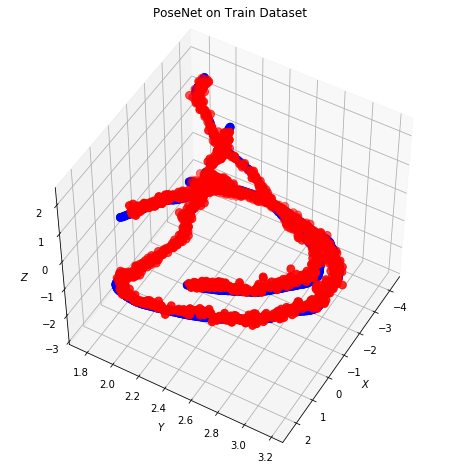

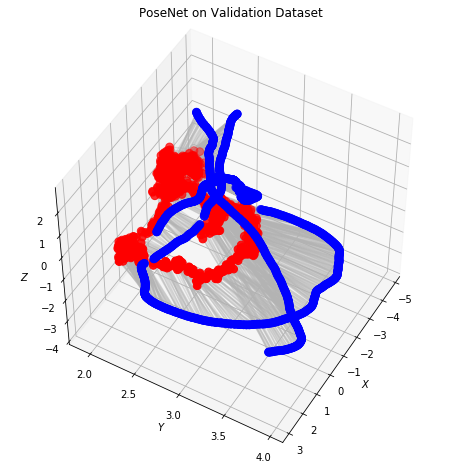

In [28]:
def set_3d_axes_limits(ax, poses, pose_format='quat'):
    p_min, p_max, p_mean, p_std = calc_poses_params(poses, pose_format=pose_format)
    ax.set_xlim(p_min[0], p_max[0])
    ax.set_ylim(p_min[1], p_max[1])
    ax.set_zlim(int(p_min[2] - 1), p_max[2])
    return p_min, p_max, p_mean, p_std

def draw_pred_gt_poses(pred_poses, gt_poses):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')

    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')
    ax.view_init(50, 30)

    all_poses = np.concatenate((pred_poses, gt_poses))
    p_min, _, _, _ = set_3d_axes_limits(ax, all_poses, pose_format='quat')
    
    draw_poses(ax, pred_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='r', s=60)
    draw_poses(ax, gt_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='b', s=60)
    for i in range(pred_poses.shape[0]):
        pp = pred_poses[i, :3]
        gp = gt_poses[i, :3]
        pps = np.vstack((pp, gp))
        ax.plot(pps[:, 0], pps[:, 1], pps[:, 2], c=(0.7, 0.7, 0.7, 0.4))
        
    plt.draw()

    
# print(pred_poses_train)
# print(gt_poses_train)

# Draw predicted vs ground truth poses
draw_pred_gt_poses(pred_poses_train, gt_poses_train)
plt.title('PoseNet on Train Dataset')
plt.show()


draw_pred_gt_poses(pred_poses_val, gt_poses_val)
plt.title('PoseNet on Validation Dataset')
plt.show()



## Save Model Checkpoint

In [26]:
# Save checkpoint
# n_epochs = 4203
save_checkpoint(model, optimizer, criterion, 'nb_{}'.format(experiment_name), n_epochs)

'_checkpoints/20200421_103542_nb_T03_e600.pth.tar'